<a href="https://colab.research.google.com/github/LiYuan199701/TimeSeries/blob/Bayesian-single-perceptron-TS/Two_Level_Variational_Bayesian_Single_Perceptron_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Two-Level Variational Bayesian Single-Perceptron model

# Imports and configuration

In [3]:
# ===============================
# Bayesian single-perceptron NAR(d)
# with recency-decaying prior means
# ===============================
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
# Set inline backend and resolution
%config InlineBackend.figure_format = 'retina'  # For Retina displays
plt.rcParams['figure.dpi'] = 150  # Set dpi to 200 for high resolution

torch.manual_seed(0)
np.random.seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate Simulated Nonlinear bounded Time Series

Text(0.5, 1.0, 'Bounded [-1,1] Time Series')

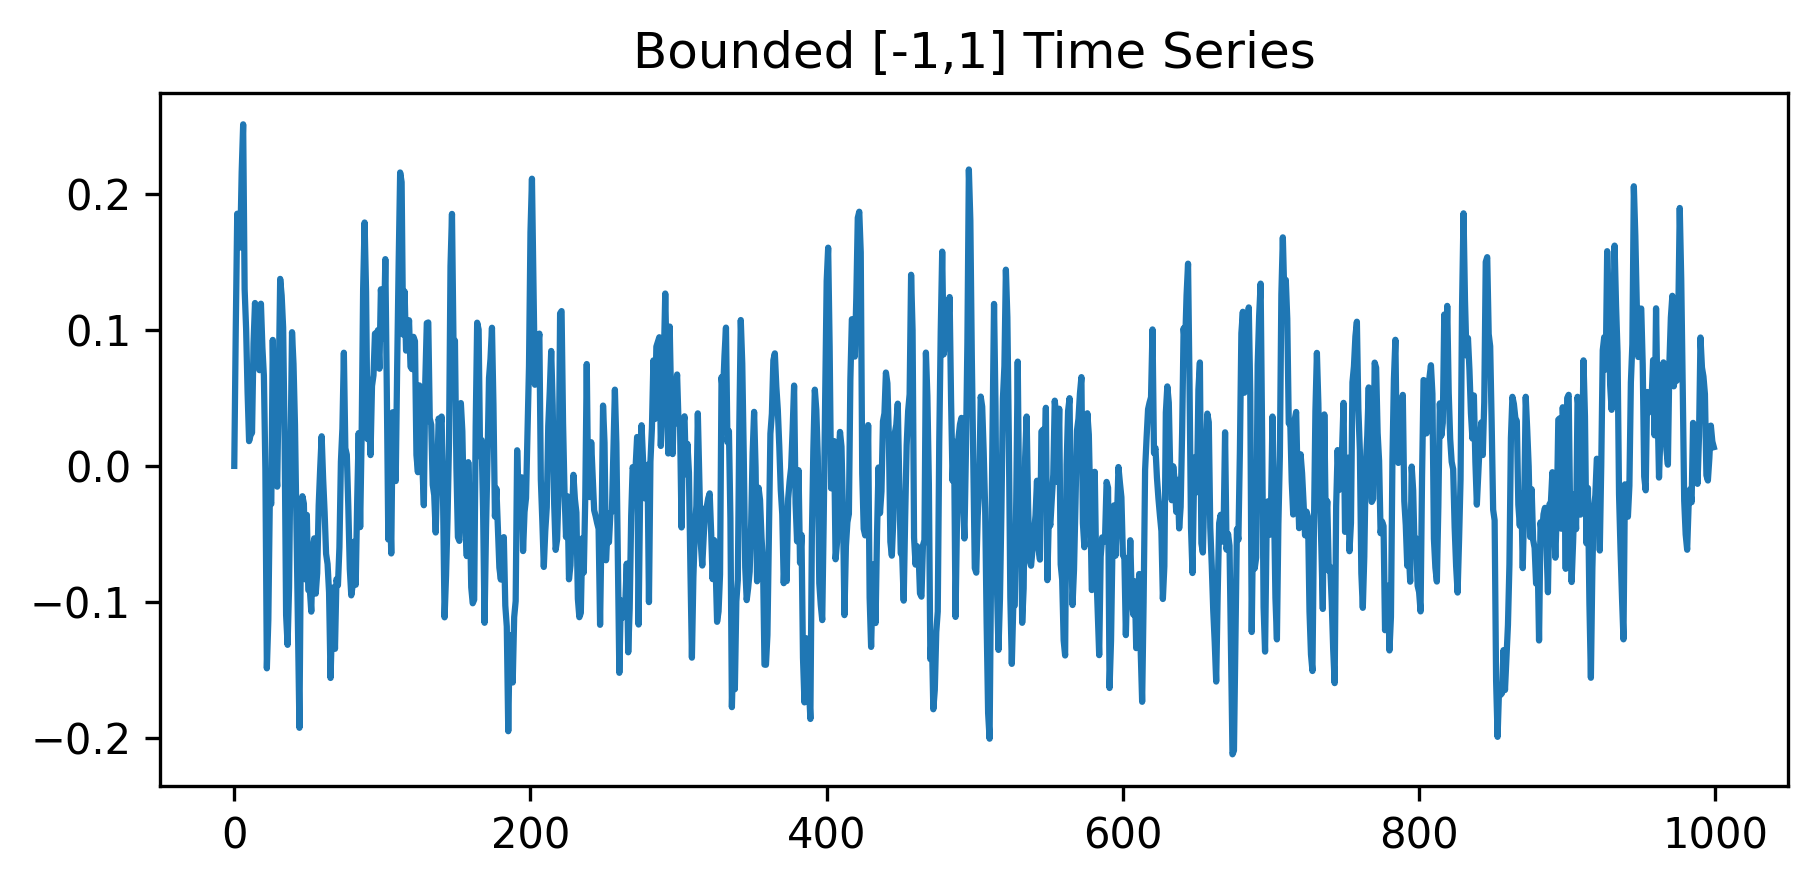

In [4]:
# -----------------------------
# 1) Simulate bounded time series
# -----------------------------
T = 1000
x = np.zeros(T)
x[0], x[1] = 0.0, 0.1
for t in range(2, T):
    x[t] = 0.7 * x[t-1] - 0.3 * x[t-2] + 0.1 * np.sin(3 * x[t-1]) + 0.05 * np.random.randn()
    x[t] = np.tanh(x[t])  # keep within [-1, 1]

# plot this time series
plt.figure(figsize=(7,3))
plt.plot(x)
plt.title("Bounded [-1,1] Time Series")

# Create lagged time series dataframe and tensor

In [5]:
# ---------------------------------
# 2) Build lagged features X_{t-1:t-d}
# ---------------------------------
def make_lagged(series, d):
    N = len(series) - d
    X = np.zeros((N, d), dtype=np.float32)
    y = np.zeros(N, dtype=np.float32)
    for i in range(N):
        # most recent first: [x_{t-1}, x_{t-2}, ..., x_{t-d}]
        X[i] = series[i:i+d][::-1]
        y[i] = series[i+d]
    return X, y

d = 4
X, y = make_lagged(x, d)
N = len(y)

# Train/val/test split by time
n_train = int(0.7*N)
n_val   = int(0.15*N)
idx_tr  = slice(0, n_train)
idx_va  = slice(n_train, n_train+n_val)
idx_te  = slice(n_train+n_val, N)

Xtr, ytr = X[idx_tr], y[idx_tr]
Xva, yva = X[idx_va], y[idx_va]
Xte, yte = X[idx_te], y[idx_te]

Xtr_t = torch.tensor(Xtr, dtype=torch.float32, device=device)
ytr_t = torch.tensor(ytr, dtype=torch.float32, device=device).unsqueeze(1)
Xva_t = torch.tensor(Xva, dtype=torch.float32, device=device)
yva_t = torch.tensor(yva, dtype=torch.float32, device=device).unsqueeze(1)
Xte_t = torch.tensor(Xte, dtype=torch.float32, device=device)
yte_t = torch.tensor(yte, dtype=torch.float32, device=device).unsqueeze(1)

# print shape and Xtr_t
print("Xtr_t shape:", Xtr_t.shape)
print(Xtr_t[:2])
print("ytr_t shape:", ytr_t.shape)
print(ytr_t[:2])
print("Xtr_t dtype:", Xtr_t.dtype)
print("Xtr_t device:", Xtr_t.device)

# form Xtr, ytr into a dataframe
df = pd.DataFrame(Xtr, columns=[f"x_{i}" for i in range(1, d+1)])
df["y"] = ytr
df.head()

Xtr_t shape: torch.Size([697, 4])
tensor([[0.1711, 0.1856, 0.1000, 0.0000],
        [0.1607, 0.1711, 0.1856, 0.1000]])
ytr_t shape: torch.Size([697, 1])
tensor([[0.1607],
        [0.2161]])
Xtr_t dtype: torch.float32
Xtr_t device: cpu


,x_1,x_2,x_3,x_4,y
0,0.171057,0.185579,0.100000,0.000000,0.160692
1,0.160692,0.171057,0.185579,0.100000,0.216112
2,0.216112,0.160692,0.171057,0.185579,0.251333
3,0.251333,0.216112,0.160692,0.171057,0.129952
4,0.129952,0.251333,0.216112,0.160692,0.100734


# Variational model with two-level prior (mean & variance decay)

In [6]:
class TwoLevelVBPerceptron(nn.Module):
    def __init__(self, d, learn_noise=True):
        super().__init__()
        self.d = d
        # variational posterior params for w
        self.m_w = nn.Parameter(torch.zeros(d))
        self.log_s_w = nn.Parameter(torch.full((d,), -1.0))
        # bias
        self.m_b = nn.Parameter(torch.tensor(0.0))
        self.log_s_b = nn.Parameter(torch.tensor(-1.0))
        # observation noise
        self.learn_noise = learn_noise
        self._log_sigma_eps = nn.Parameter(torch.tensor(-2.0))
        # hyperparameters (empirical Bayes style)
        self.c = nn.Parameter(torch.tensor(0.2))
        self.lam = nn.Parameter(torch.tensor(0.3))
        self.tau = nn.Parameter(torch.tensor(0.3))
        self.gamma = nn.Parameter(torch.tensor(0.1))
        # activation
        self.activation = torch.tanh

    def prior_mean_var(self):
        k = torch.arange(1, self.d+1, dtype=torch.float64, device=device)
        mu_p = self.c * torch.exp(-self.lam*(self.d - k))
        sigma_p = self.tau * torch.exp(self.gamma*(self.d - k))
        return mu_p, sigma_p

    def sample_wb(self, n_samples=1):
        eps = torch.randn(n_samples, self.d, device=device)
        w = self.m_w + torch.exp(self.log_s_w) * eps
        epsb = torch.randn(n_samples, 1, device=device)
        b = self.m_b + torch.exp(self.log_s_b) * epsb
        return w, b

    def kl_qp(self, mu_p, sigma_p):
        sigma_q = torch.exp(self.log_s_w)
        mu_q = self.m_w
        term = (sigma_q**2 + (mu_q - mu_p)**2) / (sigma_p**2)
        kl = 0.5 * torch.sum(torch.log(sigma_p**2/sigma_q**2) + term - 1.0)
        return kl

    def elbo(self, X, Y, n_samples=5):
        mu_p, sigma_p = self.prior_mean_var()
        wS, bS = self.sample_wb(n_samples)
        preds = self.activation(X @ wS.T + bS)
        sigma_eps = F.softplus(self._log_sigma_eps)
        ll = -0.5 * ((Y.unsqueeze(1) - preds)**2 / sigma_eps**2).sum(0).mean()
        kl = self.kl_qp(mu_p, sigma_p)
        return ll - kl, {'ll': ll.detach(), 'kl': kl.detach(), 'sigma_eps': sigma_eps.detach()}

In [9]:
# -------------------------------------------------
# 6) ELBO step with MC samples + β (KL annealing)
# -------------------------------------------------
def elbo_step(model, x, y, num_samples=3, beta=1.0):
    total_nll, total_kl = 0.0, 0.0

    for _ in range(num_samples):
        # ---- forward pass ----
        # (You can reuse model.sample_wb to draw weights each sample)
        mu_p, sigma_p = model.prior_mean_var()
        wS, bS = model.sample_wb(1)
        yhat = model.activation(x @ wS.T + bS)           # (N,1)
        sigma_eps = F.softplus(model._log_sigma_eps)
        kl = model.kl_qp(mu_p, sigma_p)

        # ---- negative log-likelihood (Gaussian up to const) ----
        nll = 0.5 * (((y - yhat)**2)/(sigma_eps**2) + 2.0*torch.log(sigma_eps)).sum()

        total_nll += nll
        total_kl  += kl

    # Monte Carlo average
    nll = total_nll / num_samples
    kl  = total_kl  / num_samples

    # Full loss (β-weighted KL)
    loss = nll + beta * kl
    mse_like = ((y - yhat)**2).mean().detach()

    return loss, nll.detach(), kl.detach(), mse_like

In [10]:
# -------------------------------------------------
# 7) Training loop with β-annealing
# -------------------------------------------------
def train_model(model, Xtr, ytr, Xva, yva,
                epochs=600, lr=3e-3, weight_decay=0.0,
                mc=3, beta_start=0.05, beta_end=1.0, beta_warmup=200, verbose=True):

    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    hist = {"train_mse": [], "val_mse": [], "beta": [],
            "c": [], "lam": [], "tau": [], "gamma": []}

    for ep in range(1, epochs + 1):
        # β linear annealing
        beta = beta_end if ep >= beta_warmup else beta_start + (beta_end - beta_start) * ep / beta_warmup

        # ---- training step ----
        model.train()
        opt.zero_grad()
        loss, nll, kl, mse = elbo_step(model, Xtr, ytr, num_samples=mc, beta=beta)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        opt.step()

        # ---- validation ----
        model.eval()
        with torch.no_grad():
            mu_p, _ = model.prior_mean_var()
            w = model.m_w
            b = model.m_b
            yhat_va = model.activation(Xva @ w + b)
            val_mse = ((yva - yhat_va)**2).mean().item()

        # ---- record history ----
        hist["train_mse"].append(mse.item())
        hist["val_mse"].append(val_mse)
        hist["beta"].append(beta)
        hist["c"].append(model.c.item())
        hist["lam"].append(model.lam.item())
        hist["tau"].append(model.tau.item())
        hist["gamma"].append(model.gamma.item())

        if verbose and ep % 100 == 0:
            print(f"Epoch {ep:4d} | β={beta:0.3f} | train MSE={mse.item():.4f} "
                  f"| val MSE={val_mse:.4f} | c={model.c.item():.3f} "
                  f"| λ={model.lam.item():.3f} | τ={model.tau.item():.3f} | γ={model.gamma.item():.3f}")

    return hist

# Training loop

Epoch  100 | β=0.367 | train MSE=0.3517 | val MSE=0.0062 | c=0.099 | λ=0.133 | τ=0.323 | γ=0.017
Epoch  200 | β=0.683 | train MSE=0.0365 | val MSE=0.0069 | c=0.097 | λ=-0.415 | τ=0.314 | γ=-0.062
Epoch  300 | β=1.000 | train MSE=0.0073 | val MSE=0.0074 | c=0.035 | λ=-0.912 | τ=0.268 | γ=-0.068
Epoch  400 | β=1.000 | train MSE=0.0145 | val MSE=0.0080 | c=0.024 | λ=-1.112 | τ=0.230 | γ=-0.049
Epoch  500 | β=1.000 | train MSE=0.0105 | val MSE=0.0085 | c=0.012 | λ=-1.384 | τ=0.196 | γ=-0.014
Epoch  600 | β=1.000 | train MSE=0.0580 | val MSE=0.0082 | c=0.008 | λ=-1.455 | τ=0.171 | γ=0.102
Epoch  700 | β=1.000 | train MSE=0.0033 | val MSE=0.0082 | c=0.008 | λ=-1.551 | τ=0.150 | γ=0.196
Epoch  800 | β=1.000 | train MSE=0.0110 | val MSE=0.0083 | c=0.006 | λ=-1.578 | τ=0.109 | γ=0.349

✅ Test MSE: 0.0094


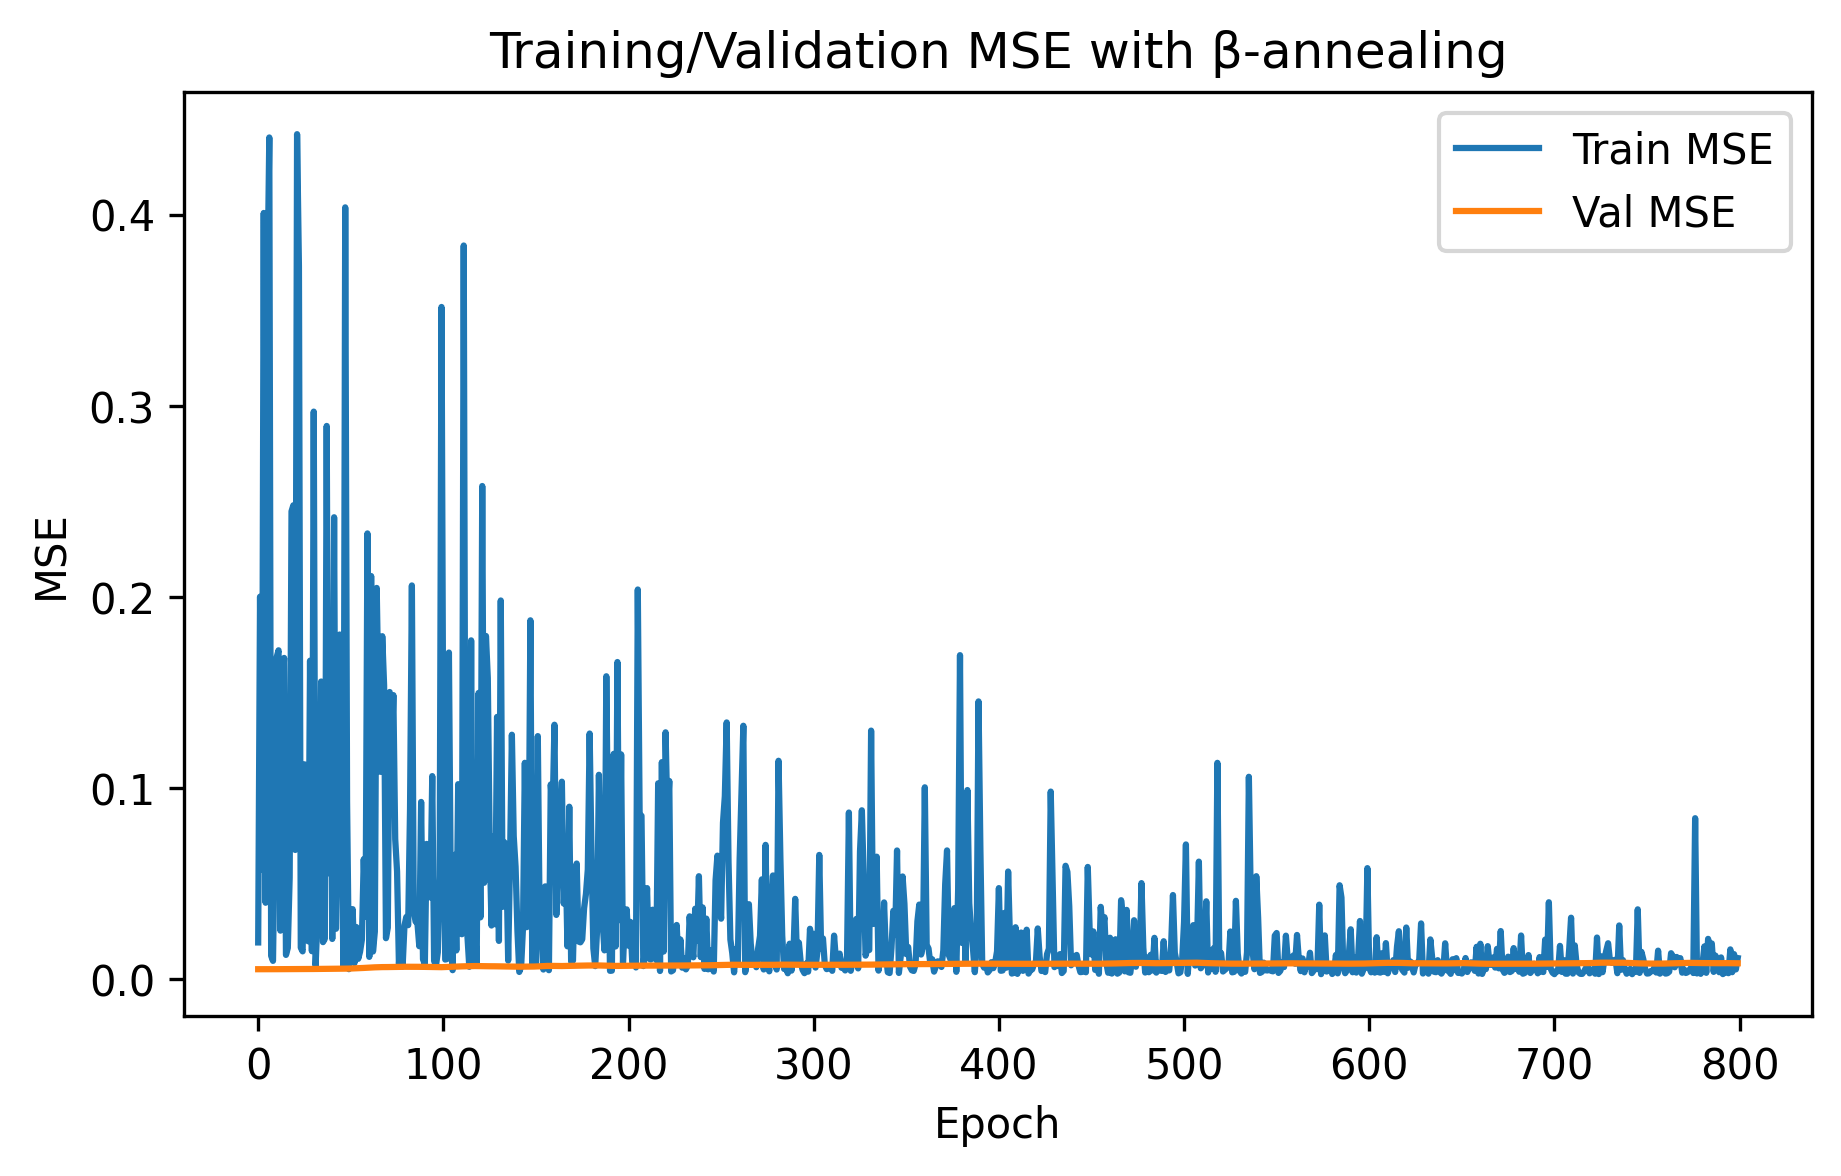

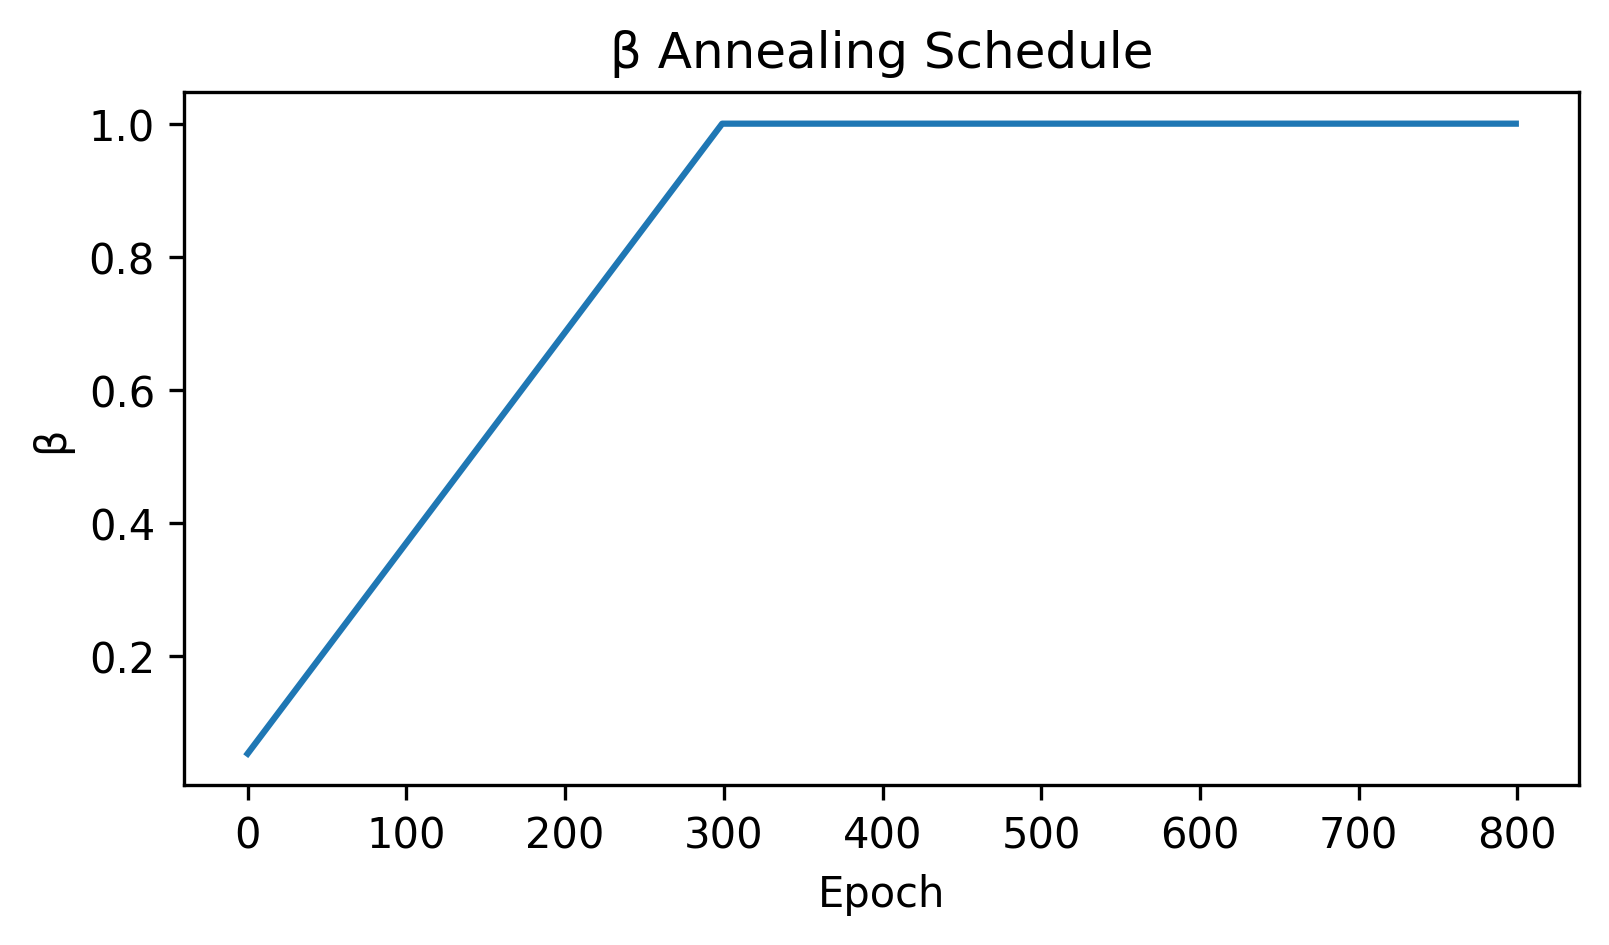

In [11]:
# ==========================================================
# 1) Instantiate the two-level variational Bayesian model
# ==========================================================
d = Xtr_t.shape[1]
model = TwoLevelVBPerceptron(d).to(device)

# ==========================================================
# 4) Run training
# ==========================================================
hist = train_model(model, Xtr_t, ytr_t, Xva_t, yva_t,
                   epochs=800, lr=3e-3, mc=5, beta_warmup=300, verbose=True)

# ==========================================================
# 5) Evaluate on test set
# ==========================================================
model.eval()
with torch.no_grad():
    yhat_te = model.activation(Xte_t @ model.m_w + model.m_b)
    test_mse = ((yte_t - yhat_te)**2).mean().item()

print(f"\n✅ Test MSE: {test_mse:.4f}")

# ==========================================================
# 6) Plot training curves
# ==========================================================
plt.figure(figsize=(7,4))
plt.plot(hist["train_mse"], label='Train MSE')
plt.plot(hist["val_mse"], label='Val MSE')
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.title("Training/Validation MSE with β-annealing")
plt.show()

plt.figure(figsize=(6,3))
plt.plot(hist["beta"])
plt.title("β Annealing Schedule")
plt.xlabel("Epoch"); plt.ylabel("β")
plt.show()

# Plot predictive uncertainty bands

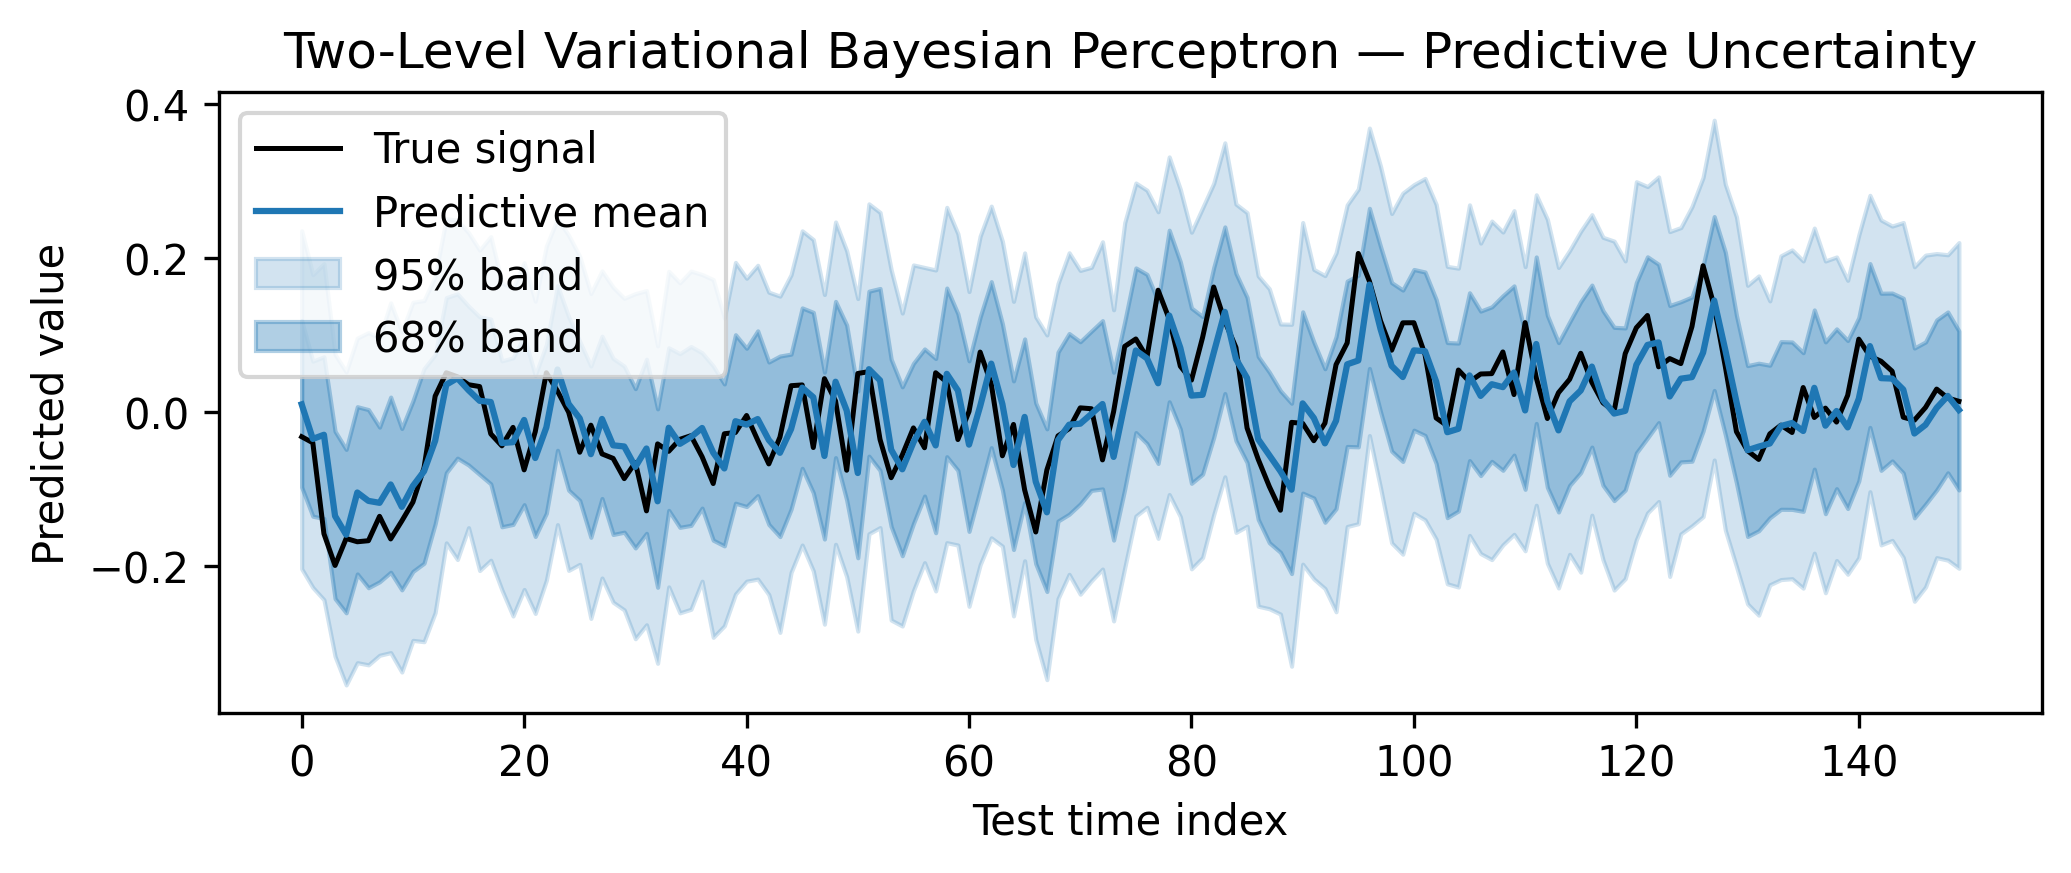

✅ Test MSE (Two-Level Model): 0.0024


In [14]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# ==========================================================
# 1) MC predictive sampler for TwoLevelVBPerceptron
# ==========================================================
@torch.no_grad()
def predict_mc_twolevel(model, X, n_samples=400, include_obs_noise=True):
    model.eval()
    preds = []
    for _ in range(n_samples):
        # ---- sample weights & bias from posterior ----
        wS, bS = model.sample_wb(1)
        yhat = model.activation(X @ wS.T + bS)  # [N,1]
        sigma_eps = F.softplus(model._log_sigma_eps)
        if include_obs_noise:
            yhat = yhat + sigma_eps * torch.randn_like(yhat)
        preds.append(yhat.squeeze(1).cpu().numpy())

    P = np.stack(preds, axis=0)   # [S, N]
    mean = P.mean(axis=0)
    lo95, hi95 = np.percentile(P, [2.5, 97.5], axis=0)
    lo68, hi68 = np.percentile(P, [16.0, 84.0], axis=0)
    return mean, (lo68, hi68), (lo95, hi95)


# ==========================================================
# 2) Run MC prediction on test set
# ==========================================================
mean_two, (lo68, hi68), (lo95, hi95) = predict_mc_twolevel(model, Xte_t, n_samples=400, include_obs_noise=True)
y_true = yte_t.squeeze(1).cpu().numpy()

# ==========================================================
# 3) Plot predictive uncertainty bands
# ==========================================================
plt.figure(figsize=(7,3))
plt.plot(y_true, label="True signal", color="black", linewidth=1.2)
plt.plot(mean_two, label="Predictive mean", color="C0", linewidth=1.5)
plt.fill_between(np.arange(len(y_true)), lo95, hi95, alpha=0.20, color="C0", label="95% band")
plt.fill_between(np.arange(len(y_true)), lo68, hi68, alpha=0.35, color="C0", label="68% band")
plt.title("Two-Level Variational Bayesian Perceptron — Predictive Uncertainty")
plt.xlabel("Test time index")
plt.ylabel("Predicted value")
plt.legend()
plt.tight_layout()
plt.show()


# ==========================================================
# 4) Numeric performance summary
# ==========================================================
mse_two = np.mean((mean_two - y_true)**2)
print(f"✅ Test MSE (Two-Level Model): {mse_two:.4f}")